## Emoviefy - A project on recommendation of movies based on expressions of a person

### Walk through of the project :
1) Uploading and extracting movie images from a zip file </br>
2) Extraction of features from using a pretrained model (VGG-16) </br>
3) Building the top-layer model from prediction </br>
4) Training the model

### Uploading and extracting movie images from a zip file
<br>
THe first step below is to import all the libraries that required for this project. This notebook contains just the training and prediction of images. TO see the development version of the code please refer to the description given in the repository. 

In [7]:
import pandas as pd 
import numpy as np
import zipfile
import tensorflow as tf 
from google.colab import files
import zipfile
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import  ImageDataGenerator, load_img, img_to_array, array_to_img
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.image as mpimg
import seaborn as sns
import os
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from google.colab import files
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
import cv2

In [ ]:
from google.colab import files
files.upload()

In order to download a datset from kaggle we will be using the kaggle API. For which you will required to download a key from your account on kaggle. Make sure the key is in the root directory. It can be done as below

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d msambare/fer2013

In [ ]:
local_zip  = '/content/fer2013.zip'

In [ ]:
def unzip(local_path):
  zip_ref = zipfile.ZipFile(local_zip,'r')
  zip_ref.extractall('/content')
  zip_ref.close()


In [ ]:
unzip(local_zip)

Data Formatting

In [ ]:
local_path = "/content/train/"

In [ ]:
folders = os.listdir(local_path )

In [ ]:
folders

['neutral', 'angry', 'happy', 'sad', 'surprise', 'fear', 'disgust']

This file is mainly used to get the filename and its label in a dataframe format. So that  they can be later utilized in a loop to perform different functions like one hot encoding the labels (for training) and for feature extraction from pretrained model.

In [ ]:
def gendata(new_path,folders):
  concatlist = []
  filename = []
  category = []
  print("Folder ordering: " , folders)
  for index,names in enumerate(folders):
      sub_dr = new_path + names+'/'
      for files in os.listdir(new_path + names+'/'):
        concatlist.append([sub_dr + files,str(index+1)])

  for i in concatlist:
    filename.append(i[0])
    category.append(i[1])
  df = pd.DataFrame({'filename': filename,
                  'category': category})
  sns.countplot(x='category',data=df).set_title("Data Distribution")
  return df

Folder ordering:  ['neutral', 'angry', 'happy', 'sad', 'surprise', 'fear', 'disgust']
Folder ordering:  ['neutral', 'angry', 'happy', 'sad', 'surprise', 'fear', 'disgust']


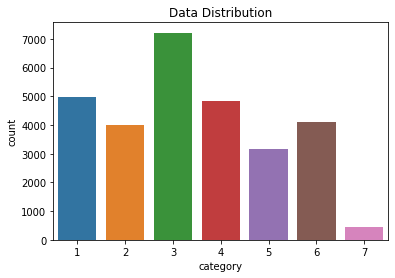

In [ ]:
train_path = "/content/train/"
test_path = '/content/test/'
train_df = gendata(train_path,folders)
test_df  = gendata(test_path,folders)

In [2]:
def encode_label(data_df):
  enc = OneHotEncoder(handle_unknown='ignore')
  enc_df = pd.DataFrame(enc.fit_transform(data_df[['category']]).toarray())
  data_df = data_df.join(enc_df)
  return data_df

In [ ]:
train_df = encode_label(train_df)
test_df = encode_label(test_df)

The below cell imports the vgg architecture cutting of the top layer. We have considered an input shape of 128 x 128 as that was the best image size that suited for achieving better results. 

In [ ]:
vgg = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(128,128,3))

for layer in vgg.layers:
    layer.trainable = False

In [ ]:
vgg.summary()

In [6]:
feature_list = []
feature_list_test = [] 

def extract_features(data_df):
    count = 0
    datalist = []
    for path in data_df['filename'].to_numpy():
        x = load_img(path,target_size=(128,128))
        img_array = img_to_array(x)
        img_array = img_array/255.0
        img_array = np.expand_dims(img_array, axis=0)
        features = vgg.predict(img_array)
        count+=1
        print(count/len(data_df)*100)
        data_list.append(features)
    return data_list

In [ ]:
feature_list =  extract_features(train_df)
feature_list_test = extract_features(test_df)

Reshaping the features in a flattened format to be passed into the dense neural netowork for prediction. I suggest extracting the features in batches and saving them in your localdrive. Rather than doing it all at once. 

In [ ]:
feat_lst = np.reshape(feature_list,(-1,4*4*512))
feat_lst_test = np.reshape(feature_list_test,(-1,4*4*512))

In [ ]:
from tensorflow.keras.regularizers import l2
input_shape = 4*4*512
def model(input_shape):
    model = tf.keras.models.Sequential([ tf.keras.layers.Dense(1024, activation = 'relu',input_shape = (input_shape,)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(512, activation = 'relu', kernel_regularizer= l2(0.01)),
                                        tf.keras.layers.Dense(256, activation = 'relu', kernel_regularizer= l2(0.01)),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(len(os.listdir(train_path)), activation= 'softmax') 
    ])
    return model

Previously the output paramaeter and encoding were done b thr image data generator but in this case there  since input is passed and features alone we have to code out the y values for calculation of the loss.

In [ ]:
y = train_df.iloc[:,2:].to_numpy() 

In [ ]:
y_vval = test_df.iloc[:,2:].to_numpy()

In [ ]:
from tensorflow.keras.optimizers import Adam
model = model(input_shape)
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ["acc"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.80):
      print("\nReached 80% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
mycallback = myCallback()
callbacks = [mycallback]

In [ ]:
steps_per_epoch = len(feat_lst)/64
validation_steps = len(feat_lst_test)/64
num_epochs = 90

history = model.fit(feat_lst,y,
                    epochs=num_epochs,
                    batch_size = 64,
                    verbose=1,
                    steps_per_epoch=steps_per_epoch,
                    validation_data = ( feat_lst_test,y_vval),
                    validation_steps=validation_steps,
                    callbacks = callbacks)

In [ ]:
model.save("vgg_updated_1_tensor.h5")
model.save_weights("vgg_weights_updated_2_tensor.h5")

In order for us to see the predictions of saw some images from the web we can used the following code,  that allows us to upload an image and then give us the predictions.

In [ ]:
uploaded = files.upload()
#imgl = []
for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(128,128))
  read_img = img_to_array(img)
  gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
  cv2.imwrite(path, gray)
  read_img = cv2.imread(path)
  read_img = np.expand_dims(read_img, axis=0) 
  read_img = read_img/255.0
  vgg_pred = vgg.predict(read_img)
  vgg_pred = vgg_pred.reshape(1, vgg_pred.shape[1]*vgg_pred.shape[2]*vgg_pred.shape[3])
  y = model.predict(vgg_pred)
  y_pred = np.argmax(y, axis=1)
  print(y_pred)